In [37]:
import pandas as pd
import torch
from transformers import EsmModel, EsmTokenizer
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from umap import UMAP
from sklearn.manifold import TSNE
import numpy as np
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter
from scipy.spatial import cKDTree

# Define the dataset path and output folder
dataset = './data/240705_all_scores_resi99.csv'
output_folder = '../../AIzymes_resi99'
esm2_model = "facebook/esm2_t6_8M_UR50D"
# esm2_model = "facebook/esm2_t33_650M_UR50D"
# esm2_model = "facebook/esm2_t36_3B_UR50D"
# esm2_model = "facebook/esm2_t48_15B_UR50D"

# Read the dataset
df = pd.read_csv(dataset)
df = df#[:100]
df = df[df['sequence'].notnull()]

# Tokenize dataset
tokenizer = EsmTokenizer.from_pretrained(esm2_model)
df['tokenized_sequence'] = [tokenizer(sequence, return_tensors='pt', padding=True, truncation=True) for sequence in df['sequence']]

# Initialize ESM model
model = EsmModel.from_pretrained(esm2_model)
model.eval()

# Forward pass function
def get_last_hidden_states(model, tokenized_sequences):
    with torch.no_grad():
        all_hidden_states = []
        for seq in tokenized_sequences:
            output = model(**seq)
            hidden_states = output.last_hidden_state.squeeze(0).mean(dim=0).cpu().numpy()
            all_hidden_states.append(hidden_states)
        return all_hidden_states

# Get last hidden states
df['last_hidden_state'] = get_last_hidden_states(model, df['tokenized_sequence'])

# Dimensionality reduction
values = np.array(df['last_hidden_state'].to_list())
umap = UMAP()
df[['umap_x', 'umap_y']] = UMAP().fit_transform(values)
tsne = TSNE(n_components = 2)
df[['tsne_x', 'tsne_y']] = tsne.fit_transform(values)
pca = PCA(n_components=2)
df[['pca_x', 'pca_y']] = pca.fit_transform(values)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


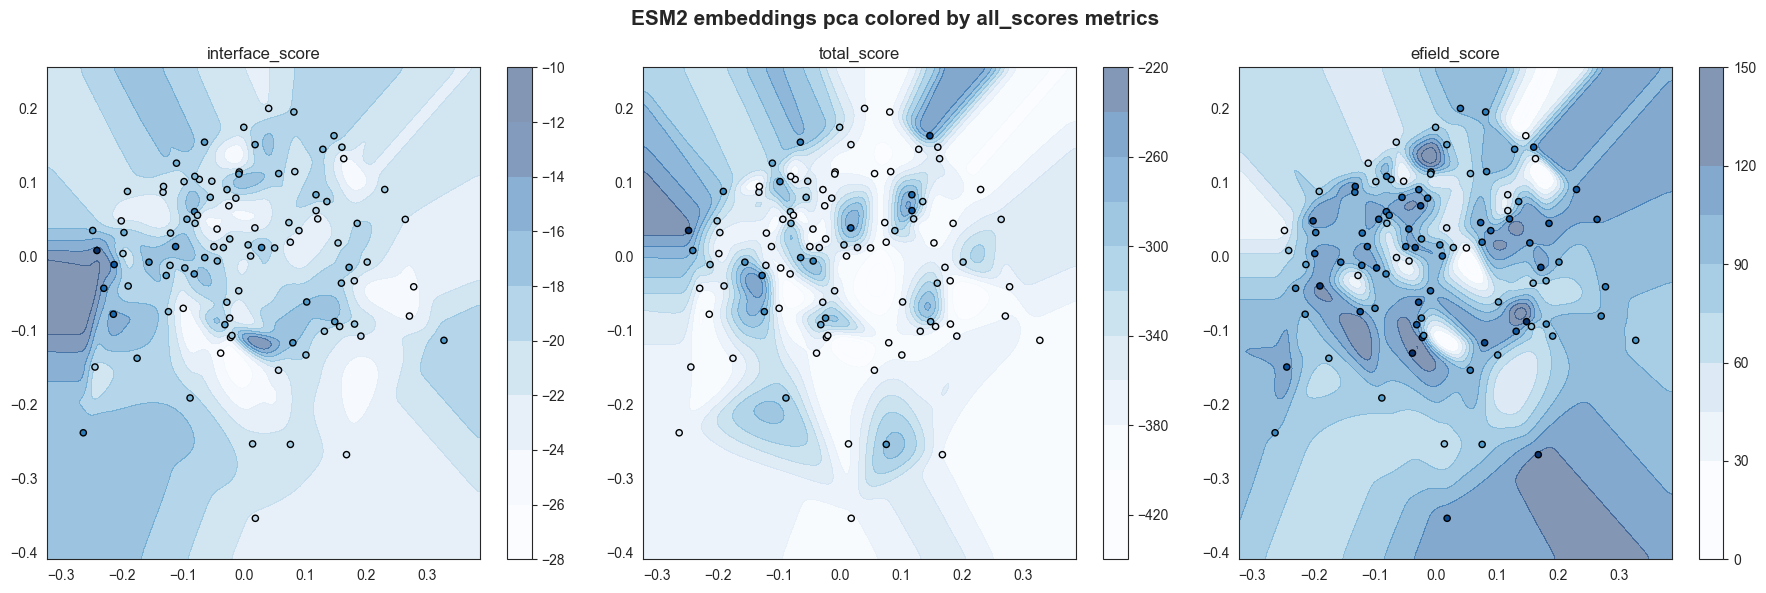

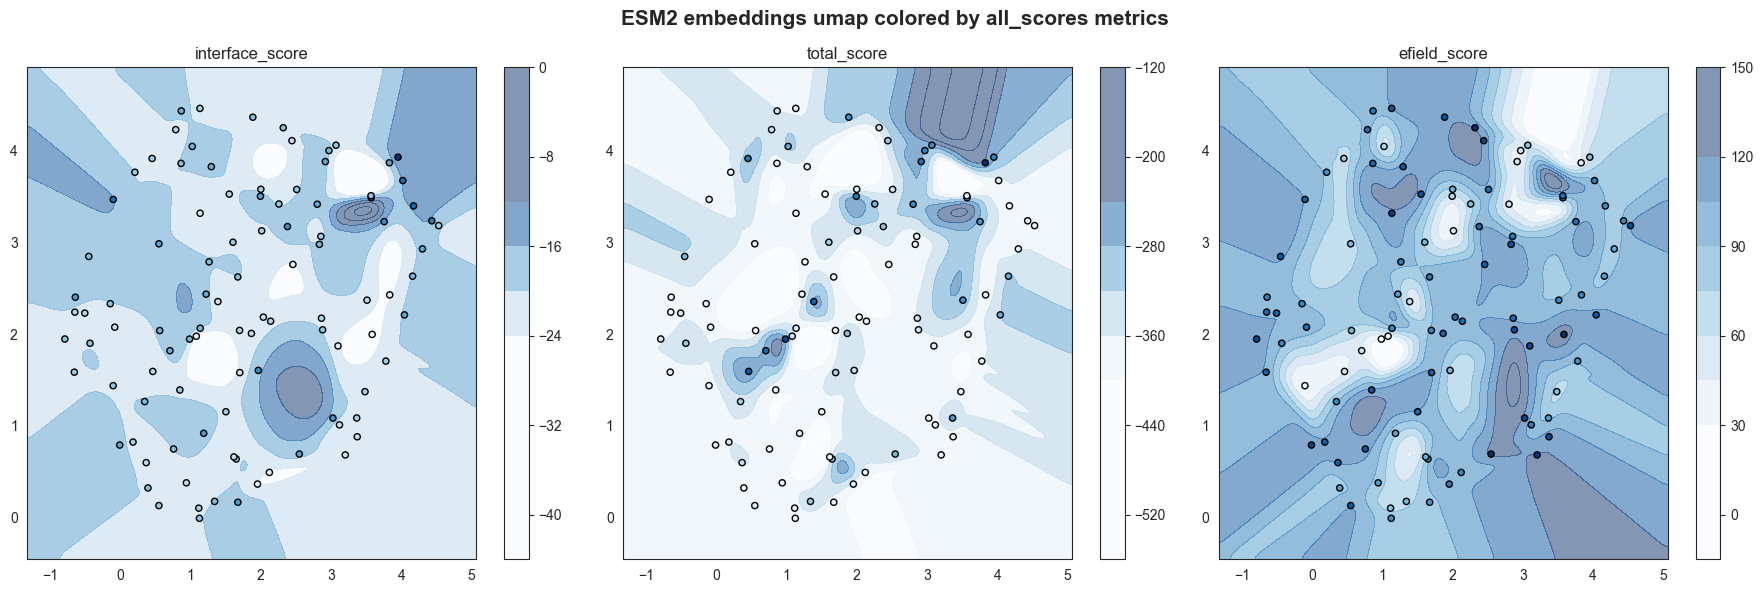

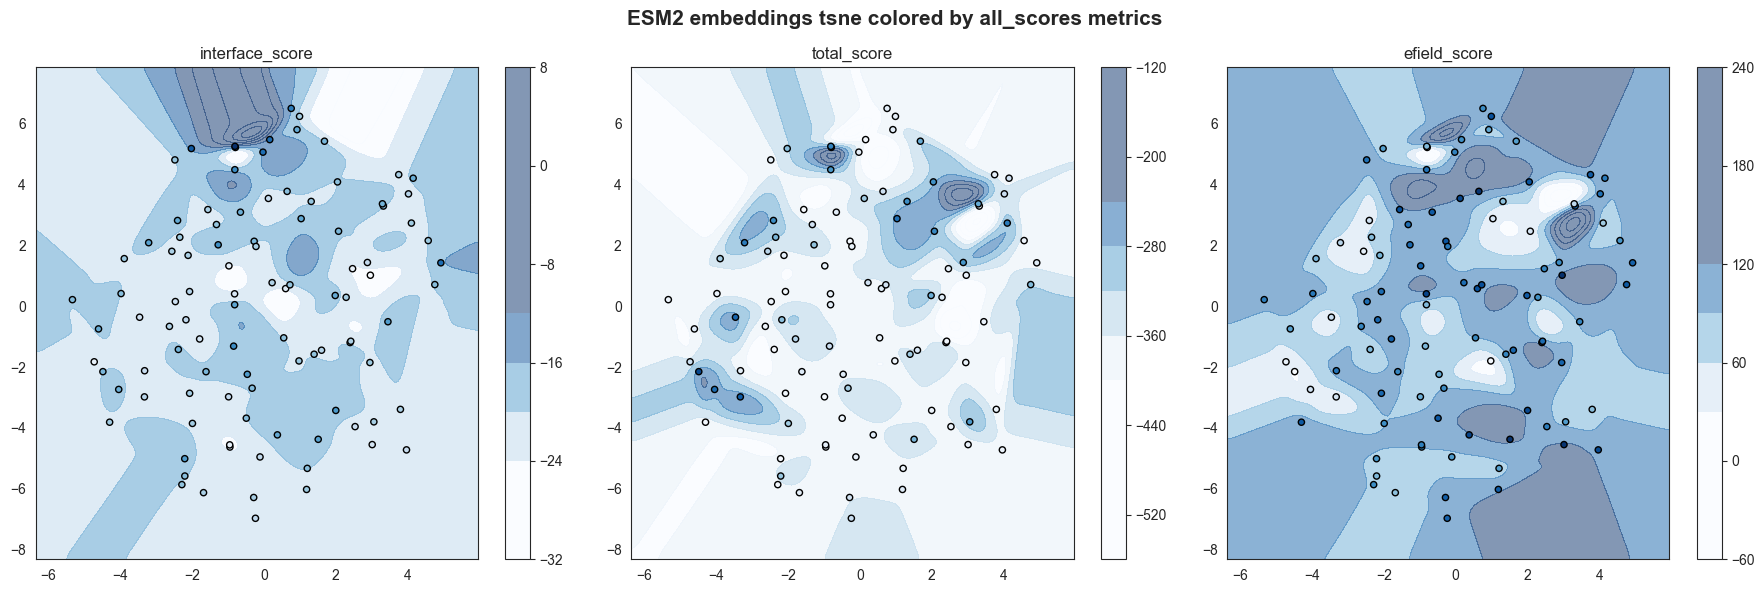

In [ ]:
def fill_nans_with_nearest(array):
    """Fill NaN values in an array using nearest-neighbor interpolation."""
    # Find the NaN elements
    nan_idx = np.isnan(array)
    
    # Create a KDTree for the non-NaN elements
    x, y = np.indices(array.shape)
    coords = np.column_stack((x[~nan_idx], y[~nan_idx]))
    values = array[~nan_idx]
    
    tree = cKDTree(coords)
    
    # Query the nearest neighbors for the NaN elements
    nan_coords = np.column_stack((x[nan_idx], y[nan_idx]))
    _, nearest_idx = tree.query(nan_coords)
    
    array[nan_idx] = values[nearest_idx]
    return array

# Plotting
for dim in ['pca', 'umap', 'tsne']:
    sns.set_style("white")
    plt.style.use('tableau-colorblind10')

    fig, axs = plt.subplots(2, 3, figsize=(12, 4))
    fig.suptitle(f'ESM2 embeddings {dim} colored by all_scores metrics', fontsize=15, weight='bold')

    for idx, feature in enumerate(['interface_score', 'total_score', 'efield_score','generation']):

        # Get the data
        x = df[f'{dim}_x']
        y = df[f'{dim}_y']
        z = df[feature]
        vmin, vmax = z.min(), z.max()

        # Scatter plot
        scatter = axs[0, idx].scatter(x, y, c=z, cmap='Blues', s=20, vmin=vmin, vmax=vmax, zorder=10)
        axs[0, idx].set_title(feature)

        # Extend limits by 10%
        x_margin = (x.max() - x.min()) * 0.1
        y_margin = (y.max() - y.min()) * 0.1
        x_min, x_max = x.min() - x_margin, x.max() + x_margin
        y_min, y_max = y.min() - y_margin, y.max() + y_margin

        # Surface plot using cubic interpolation
        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))  
        zz = griddata((x, y), z, (xx, yy), method='cubic')
        zz = fill_nans_with_nearest(zz)
        zz = gaussian_filter(zz, sigma=2)

        # Plot filled contour
        contour = axs[1, idx].contourf(xx, yy, zz, levels=10, cmap='Blues', alpha=0.5, zorder=1, vmin=vmin, vmax=vmax)
        
        # Add colorbar
        fig.colorbar(contour, ax=axs[1, idx], orientation='vertical')

    plt.tight_layout()
    plt.show()
